In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.optim as optim

In [9]:
matplotlib.rcParams['figure.dpi'] = 100
torch.manual_seed(789)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
batch_size_train = 256
batch_size_test = 1024

# Load the MNIST Dataset

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_data = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.MNIST(
    'data/', 
    train=False, 
    download=True,
    transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    pin_memory=True,
    num_workers=6,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test, 
    pin_memory=True,
    num_workers=6,
    shuffle=True)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 60000
Test size: 10000


## Visualizing

In [12]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([256, 1, 28, 28])

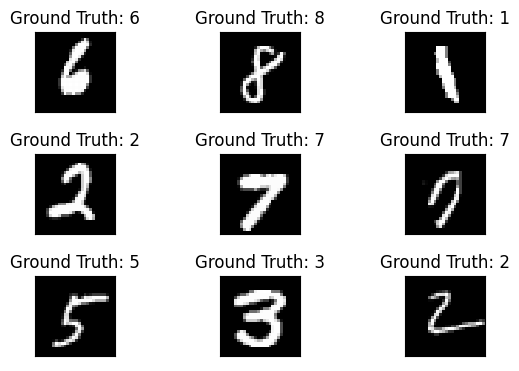

In [13]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(f"Ground Truth: {example_targets[i]}")
  plt.xticks([])
  plt.yticks([])

<figure>
    <img src="images/one_image_to_2darray.png" alt="image_to_matrix">
    <figcaption>Source: https://colah.github.io/posts/2014-10-Visualizing-MNIST/ <figcaption>
<figure> 

# Architecture

## Interface
<figure>
    <img src="images/expected_behaviour.png" alt="6_probabilities">
<figure>  

## Flattening
<figure>
    <img src="images/mnist_flatten.png" alt="A kitten">
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure>  

## Matrix Representation
<figure>
    <img src="images/mnist_matrix_multiplication_batch.png" alt="A kitten">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

# Defining a model in pytorch

In [10]:
class NeuralNetwork_v1(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, n_classes)
        )
    def forward(self, x):
        output = self.nn_stack(x)
        
        # compute softmax
        output = nn.functional.log_softmax(output)
        return output

# How do we measure success?

## Step 1: Compute distance between computed value and actual value
<figure>
    <img src="images/cross_entropy.png" alt="loss_function">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

## Step 2: Take a step to reduce that distance
<figure>
    <img src="images/gradient_descent.png" alt="loss_function">
    <br><br>
    <figcaption>Source: https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/ <figcaption>
<figure> 

# Code implementation

In [7]:
def one_train_epoch(train_data, model, loss_fn, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU
        data = data.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        
        # Flatten Data
        data = data.view(-1, 784)
        optimizer.zero_grad()
        
        # Predictions
        output = model(data)
        
        # Compute Loss
        train_loss = loss_fn(output, target)
        
        # Track metrics
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).sum().cpu()
        train_accuracy.append(correct/len(data))
        train_losses.append(train_loss.item())
        train_counter.append(batch_idx*batch_size_train + epoch*len(train_loader.dataset))
        
        if batch_idx % 10 == 0:
            print(f"loss: {train_loss.item():>7f}  [{batch_idx * len(data):>5d}/{len(train_loader.dataset):>5d}]")
        
        # Backprop
        train_loss.backward()
        optimizer.step()
    return train_loss

In [8]:
def test(test_data, model, loss_fn, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_data:
            data = data.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
            data = data.view(-1, 784)
            output = model(data)
            test_loss += loss_fn(output, target, reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().cpu()
            
    test_loss /= len(test_loader.dataset)
    
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    test_counter.append(epoch*len(train_loader.dataset))
    print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n')

## Training hyperparameters

In [9]:
epochs = 35
learning_rate = 0.01

loss_fn = nn.functional.nll_loss

In [11]:
model = NeuralNetwork_v1(784, 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr = learning_rate, 
                            )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses = []
train_accuracy = []
train_counter = []

test_losses = []
test_accuracy = []
test_counter = []

test(test_loader, model, loss_fn, 0)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
    test(test_loader, model, loss_fn, epoch+1)
print("Done!")

/tmp/ipykernel_324065/3146421046.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.functional.log_softmax(output)



Test set: Avg. loss: 2.4626, Accuracy: 569/10000 (5.69%)

Epoch 1, lr: 0.01
-------------------------------
loss: 2.484751  [    0/60000]
loss: 0.555668  [ 2560/60000]
loss: 0.325019  [ 5120/60000]
loss: 0.431387  [ 7680/60000]
loss: 0.453088  [10240/60000]
loss: 0.282239  [12800/60000]
loss: 0.399624  [15360/60000]
loss: 0.328156  [17920/60000]
loss: 0.390574  [20480/60000]
loss: 0.393517  [23040/60000]
loss: 0.434367  [25600/60000]
loss: 0.306598  [28160/60000]
loss: 0.300996  [30720/60000]
loss: 0.237391  [33280/60000]
loss: 0.335325  [35840/60000]
loss: 0.282015  [38400/60000]
loss: 0.422261  [40960/60000]
loss: 0.460788  [43520/60000]
loss: 0.511782  [46080/60000]
loss: 0.311834  [48640/60000]
loss: 0.393097  [51200/60000]
loss: 0.373367  [53760/60000]
loss: 0.288486  [56320/60000]
loss: 0.340796  [58880/60000]

Test set: Avg. loss: 0.3508, Accuracy: 9011/10000 (90.11%)

Epoch 2, lr: 0.01
-------------------------------
loss: 0.468518  [    0/60000]
loss: 0.342568  [ 2560/60000]


loss: 0.282476  [46080/60000]
loss: 0.253688  [48640/60000]
loss: 0.252091  [51200/60000]
loss: 0.227313  [53760/60000]
loss: 0.244880  [56320/60000]
loss: 0.160204  [58880/60000]
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.

Test set: Avg. loss: 0.2788, Accuracy: 9249/10000 (92.49%)

Epoch 11, lr: 0.0001
-------------------------------
loss: 0.252579  [    0/60000]
loss: 0.183570  [ 2560/60000]
loss: 0.258615  [ 5120/60000]
loss: 0.288600  [ 7680/60000]
loss: 0.169985  [10240/60000]
loss: 0.165836  [12800/60000]
loss: 0.214785  [15360/60000]
loss: 0.247737  [17920/60000]
loss: 0.116999  [20480/60000]
loss: 0.180501  [23040/60000]
loss: 0.242539  [25600/60000]
loss: 0.248993  [28160/60000]
loss: 0.161145  [30720/60000]
loss: 0.207457  [33280/60000]
loss: 0.206998  [35840/60000]
loss: 0.305041  [38400/60000]
loss: 0.275656  [40960/60000]
loss: 0.216730  [43520/60000]
loss: 0.267882  [46080/60000]
loss: 0.273863  [48640/60000]
loss: 0.200127  [51200/60000]
loss: 0.169486

loss: 0.145328  [30720/60000]
loss: 0.184614  [33280/60000]
loss: 0.242431  [35840/60000]
loss: 0.256919  [38400/60000]
loss: 0.203964  [40960/60000]
loss: 0.325258  [43520/60000]
loss: 0.218304  [46080/60000]
loss: 0.203000  [48640/60000]
loss: 0.230050  [51200/60000]
loss: 0.191517  [53760/60000]
loss: 0.216062  [56320/60000]
loss: 0.334820  [58880/60000]
Epoch    20: reducing learning rate of group 0 to 1.0000e-05.

Test set: Avg. loss: 0.2749, Accuracy: 9251/10000 (92.51%)

Epoch 21, lr: 1e-05
-------------------------------
loss: 0.326953  [    0/60000]
loss: 0.198830  [ 2560/60000]
loss: 0.226445  [ 5120/60000]
loss: 0.238732  [ 7680/60000]
loss: 0.240956  [10240/60000]
loss: 0.241294  [12800/60000]
loss: 0.235176  [15360/60000]
loss: 0.159050  [17920/60000]
loss: 0.129613  [20480/60000]
loss: 0.182300  [23040/60000]
loss: 0.218715  [25600/60000]
loss: 0.179029  [28160/60000]
loss: 0.259165  [30720/60000]
loss: 0.234419  [33280/60000]
loss: 0.214825  [35840/60000]
loss: 0.263946 

loss: 0.260988  [    0/60000]
loss: 0.145187  [ 2560/60000]
loss: 0.160023  [ 5120/60000]
loss: 0.218767  [ 7680/60000]
loss: 0.171349  [10240/60000]
loss: 0.255981  [12800/60000]
loss: 0.300805  [15360/60000]
loss: 0.193053  [17920/60000]
loss: 0.209379  [20480/60000]
loss: 0.173941  [23040/60000]
loss: 0.267608  [25600/60000]
loss: 0.149469  [28160/60000]
loss: 0.298312  [30720/60000]
loss: 0.147633  [33280/60000]
loss: 0.196785  [35840/60000]
loss: 0.283696  [38400/60000]
loss: 0.176129  [40960/60000]
loss: 0.263147  [43520/60000]
loss: 0.215626  [46080/60000]
loss: 0.192686  [48640/60000]
loss: 0.235866  [51200/60000]
loss: 0.213757  [53760/60000]
loss: 0.140294  [56320/60000]
loss: 0.236406  [58880/60000]

Test set: Avg. loss: 0.2743, Accuracy: 9262/10000 (92.62%)

Epoch 31, lr: 1.0000000000000002e-07
-------------------------------
loss: 0.230210  [    0/60000]
loss: 0.238932  [ 2560/60000]
loss: 0.218197  [ 5120/60000]
loss: 0.233893  [ 7680/60000]
loss: 0.247406  [10240/60000]


In [12]:
print(f"Peak Test Accuracy :{max(test_accuracy):.3f}")
print(f"Peak Train Accuracy :{max(train_accuracy):.3f}")

Peak Test Accuracy :0.927
Peak Train Accuracy :0.990


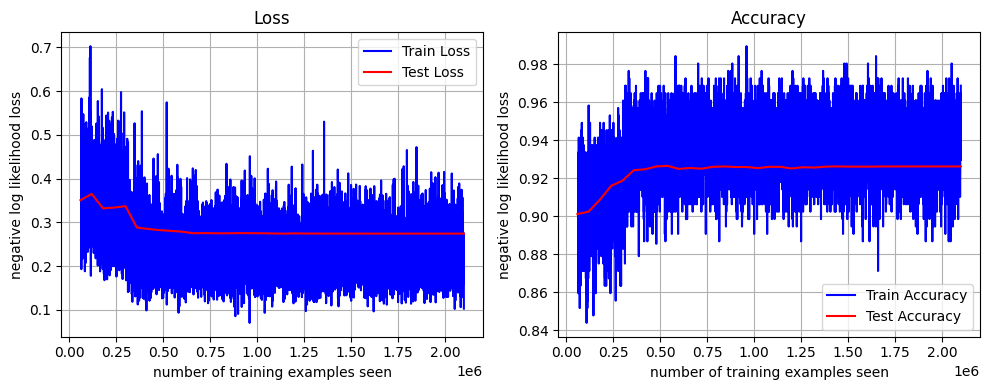

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(train_counter[250:], train_losses[250:], label = "Train Loss", color='blue')
ax[0].plot(test_counter[1:], test_losses[1:], label = "Test Loss", color='red')
ax[0].set_title("Loss")
ax[0].legend(loc="upper right")
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative log likelihood loss')
ax[0].grid(True)

ax[1].plot(train_counter[250:], train_accuracy[250:], label = "Train Accuracy", color='blue')
ax[1].plot(test_counter[1:], test_accuracy[1:], label = "Test Accuracy", color='red')
ax[1].set_title("Accuracy")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('negative log likelihood loss')
ax[1].grid(True)
plt.tight_layout(h_pad=5)

# Deep Learning! Let's try adding some more layers

<figure>
    <img src="images/go_deep!.png" alt="Deep Leanring">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

## How about 5? 

<figure>
    <img src="images/add_more_layers.png" alt="Deep Learning">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

In [14]:
class NeuralNetwork_v2(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, n_classes),
        )
    def forward(self, x):
        output = self.nn_stack(x)
        
        # compute softmax
        output = nn.functional.log_softmax(output)
        return output

In [15]:
model = NeuralNetwork_v2(784, 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr = learning_rate, 
                            )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)


train_losses = []
train_accuracy = []
train_counter = []

test_losses = []
test_accuracy = []
test_counter = []

test(test_loader, model, loss_fn, 0)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
    test(test_loader, model, loss_fn, epoch+1)
print("Done!")

/tmp/ipykernel_324065/3683493287.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.functional.log_softmax(output)



Test set: Avg. loss: 2.3080, Accuracy: 892/10000 (8.92%)

Epoch 1, lr: 0.01
-------------------------------
loss: 2.305101  [    0/60000]
loss: 1.201852  [ 2560/60000]
loss: 0.704790  [ 5120/60000]
loss: 0.529007  [ 7680/60000]
loss: 0.414813  [10240/60000]
loss: 0.405043  [12800/60000]
loss: 0.272067  [15360/60000]
loss: 0.265448  [17920/60000]
loss: 0.225949  [20480/60000]
loss: 0.230547  [23040/60000]
loss: 0.175780  [25600/60000]
loss: 0.208159  [28160/60000]
loss: 0.250971  [30720/60000]
loss: 0.292448  [33280/60000]
loss: 0.225395  [35840/60000]
loss: 0.202821  [38400/60000]
loss: 0.186527  [40960/60000]
loss: 0.130258  [43520/60000]
loss: 0.204485  [46080/60000]
loss: 0.240397  [48640/60000]
loss: 0.156188  [51200/60000]
loss: 0.215641  [53760/60000]
loss: 0.194161  [56320/60000]
loss: 0.079477  [58880/60000]

Test set: Avg. loss: 0.1669, Accuracy: 9504/10000 (95.04%)

Epoch 2, lr: 0.01
-------------------------------
loss: 0.147931  [    0/60000]
loss: 0.136696  [ 2560/60000]


loss: 0.022067  [51200/60000]
loss: 0.016415  [53760/60000]
loss: 0.004107  [56320/60000]
loss: 0.004293  [58880/60000]

Test set: Avg. loss: 0.0877, Accuracy: 9798/10000 (97.98%)

Epoch 11, lr: 0.001
-------------------------------
loss: 0.036944  [    0/60000]
loss: 0.011383  [ 2560/60000]
loss: 0.011003  [ 5120/60000]
loss: 0.011304  [ 7680/60000]
loss: 0.053984  [10240/60000]
loss: 0.014904  [12800/60000]
loss: 0.008010  [15360/60000]
loss: 0.014689  [17920/60000]
loss: 0.008340  [20480/60000]
loss: 0.001537  [23040/60000]
loss: 0.008264  [25600/60000]
loss: 0.020452  [28160/60000]
loss: 0.008888  [30720/60000]
loss: 0.002599  [33280/60000]
loss: 0.015143  [35840/60000]
loss: 0.020710  [38400/60000]
loss: 0.002392  [40960/60000]
loss: 0.005702  [43520/60000]
loss: 0.007147  [46080/60000]
loss: 0.012018  [48640/60000]
loss: 0.002205  [51200/60000]
loss: 0.017087  [53760/60000]
loss: 0.014193  [56320/60000]
loss: 0.002949  [58880/60000]

Test set: Avg. loss: 0.0920, Accuracy: 9799/10

loss: 0.001309  [38400/60000]
loss: 0.000386  [40960/60000]
loss: 0.000768  [43520/60000]
loss: 0.000043  [46080/60000]
loss: 0.000253  [48640/60000]
loss: 0.006210  [51200/60000]
loss: 0.000136  [53760/60000]
loss: 0.001061  [56320/60000]
loss: 0.001128  [58880/60000]

Test set: Avg. loss: 0.1359, Accuracy: 9799/10000 (97.99%)

Epoch 21, lr: 0.0001
-------------------------------
loss: 0.000116  [    0/60000]
loss: 0.000096  [ 2560/60000]
loss: 0.000528  [ 5120/60000]
loss: 0.000246  [ 7680/60000]
loss: 0.000461  [10240/60000]
loss: 0.000101  [12800/60000]
loss: 0.000645  [15360/60000]
loss: 0.001836  [17920/60000]
loss: 0.000344  [20480/60000]
loss: 0.000493  [23040/60000]
loss: 0.000653  [25600/60000]
loss: 0.000436  [28160/60000]
loss: 0.000302  [30720/60000]
loss: 0.007461  [33280/60000]
loss: 0.000102  [35840/60000]
loss: 0.014079  [38400/60000]
loss: 0.000183  [40960/60000]
loss: 0.004329  [43520/60000]
loss: 0.000690  [46080/60000]
loss: 0.000234  [48640/60000]
loss: 0.002120  

loss: 0.006057  [23040/60000]
loss: 0.000628  [25600/60000]
loss: 0.000149  [28160/60000]
loss: 0.000181  [30720/60000]
loss: 0.000952  [33280/60000]
loss: 0.000369  [35840/60000]
loss: 0.000574  [38400/60000]
loss: 0.000145  [40960/60000]
loss: 0.000425  [43520/60000]
loss: 0.000250  [46080/60000]
loss: 0.000229  [48640/60000]
loss: 0.000142  [51200/60000]
loss: 0.003753  [53760/60000]
loss: 0.000194  [56320/60000]
loss: 0.000077  [58880/60000]
Epoch    30: reducing learning rate of group 0 to 1.0000e-06.

Test set: Avg. loss: 0.1442, Accuracy: 9799/10000 (97.99%)

Epoch 31, lr: 1.0000000000000002e-06
-------------------------------
loss: 0.000144  [    0/60000]
loss: 0.002188  [ 2560/60000]
loss: 0.000774  [ 5120/60000]
loss: 0.000330  [ 7680/60000]
loss: 0.002754  [10240/60000]
loss: 0.000211  [12800/60000]
loss: 0.000924  [15360/60000]
loss: 0.000779  [17920/60000]
loss: 0.000090  [20480/60000]
loss: 0.000921  [23040/60000]
loss: 0.000186  [25600/60000]
loss: 0.017223  [28160/60000

In [16]:
print(f"Peak Test Accuracy :{max(test_accuracy):.3f}")
print(f"Peak Train Accuracy :{max(train_accuracy):.3f}")

Peak Test Accuracy :0.980
Peak Train Accuracy :1.000


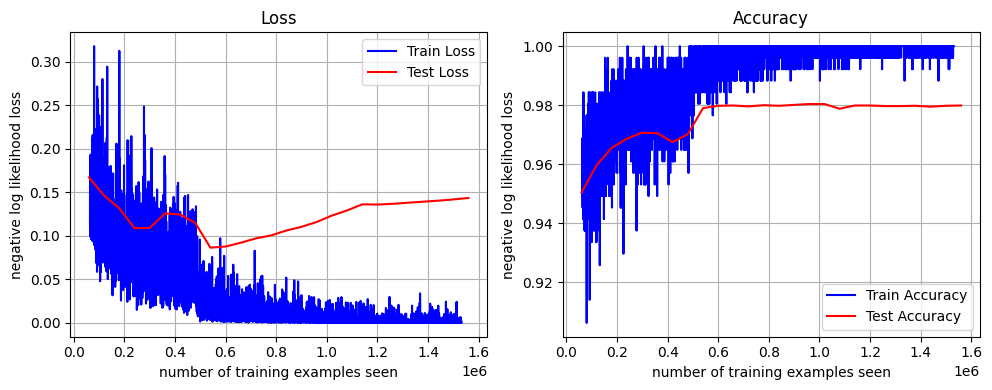

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(train_counter[250:6000], train_losses[250:6000], label = "Train Loss", color='blue')
ax[0].plot(test_counter[1:27], test_losses[1:27], label = "Test Loss", color='red')
ax[0].set_title("Loss")
ax[0].legend(loc="upper right")
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative log likelihood loss')
ax[0].grid(True)

ax[1].plot(train_counter[250:6000], train_accuracy[250:6000], label = "Train Accuracy", color='blue')
ax[1].plot(test_counter[1:27], test_accuracy[1:27], label = "Test Accuracy", color='red')
ax[1].set_title("Accuracy")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('negative log likelihood loss')
ax[1].grid(True)
plt.tight_layout(h_pad=5)

## Avoid the Overfit with Dropout!
<figure>
    <img src="images/dropout_art.png" alt="Deep Leanring">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

<figure>
    <img src="images/dropout_repr.png" alt="Dropout">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

In [18]:
class NeuralNetwork_v3(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, n_classes),
        )
    def forward(self, x):
        output = self.nn_stack(x)
        
        # compute softmax
        output = nn.functional.log_softmax(output)
        return output

In [19]:
model = NeuralNetwork_v3(784, 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr = learning_rate, 
                            )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)


train_losses = []
train_accuracy = []
train_counter = []

test_losses = []
test_accuracy = []
test_counter = []

test(test_loader, model, loss_fn, 0)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
    test(test_loader, model, loss_fn, epoch+1)
print("Done!")

/tmp/ipykernel_324065/2756999883.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.functional.log_softmax(output)



Test set: Avg. loss: 2.3062, Accuracy: 892/10000 (8.92%)

Epoch 1, lr: 0.01
-------------------------------
loss: 2.313906  [    0/60000]
loss: 1.200519  [ 2560/60000]
loss: 0.722132  [ 5120/60000]
loss: 0.594906  [ 7680/60000]
loss: 0.386110  [10240/60000]
loss: 0.340817  [12800/60000]
loss: 0.302839  [15360/60000]
loss: 0.344197  [17920/60000]
loss: 0.289600  [20480/60000]
loss: 0.441126  [23040/60000]
loss: 0.258060  [25600/60000]
loss: 0.335061  [28160/60000]
loss: 0.328318  [30720/60000]
loss: 0.299146  [33280/60000]
loss: 0.233304  [35840/60000]
loss: 0.340585  [38400/60000]
loss: 0.156480  [40960/60000]
loss: 0.209929  [43520/60000]
loss: 0.295481  [46080/60000]
loss: 0.275513  [48640/60000]
loss: 0.151569  [51200/60000]
loss: 0.194875  [53760/60000]
loss: 0.291464  [56320/60000]
loss: 0.160362  [58880/60000]

Test set: Avg. loss: 0.1467, Accuracy: 9588/10000 (95.88%)

Epoch 2, lr: 0.01
-------------------------------
loss: 0.160980  [    0/60000]
loss: 0.166949  [ 2560/60000]


loss: 0.091254  [53760/60000]
loss: 0.083779  [56320/60000]
loss: 0.162902  [58880/60000]

Test set: Avg. loss: 0.1231, Accuracy: 9702/10000 (97.02%)

Epoch 11, lr: 0.01
-------------------------------
loss: 0.102113  [    0/60000]
loss: 0.116331  [ 2560/60000]
loss: 0.142764  [ 5120/60000]
loss: 0.081289  [ 7680/60000]
loss: 0.181052  [10240/60000]
loss: 0.111825  [12800/60000]
loss: 0.057944  [15360/60000]
loss: 0.061993  [17920/60000]
loss: 0.145729  [20480/60000]
loss: 0.095548  [23040/60000]
loss: 0.070886  [25600/60000]
loss: 0.045575  [28160/60000]
loss: 0.125960  [30720/60000]
loss: 0.138262  [33280/60000]
loss: 0.144855  [35840/60000]
loss: 0.093386  [38400/60000]
loss: 0.080922  [40960/60000]
loss: 0.075721  [43520/60000]
loss: 0.156807  [46080/60000]
loss: 0.088031  [48640/60000]
loss: 0.074060  [51200/60000]
loss: 0.073319  [53760/60000]
loss: 0.115322  [56320/60000]
loss: 0.082008  [58880/60000]

Test set: Avg. loss: 0.1182, Accuracy: 9752/10000 (97.52%)

Epoch 12, lr: 0.0

loss: 0.048793  [38400/60000]
loss: 0.058149  [40960/60000]
loss: 0.021166  [43520/60000]
loss: 0.027893  [46080/60000]
loss: 0.037943  [48640/60000]
loss: 0.060286  [51200/60000]
loss: 0.030985  [53760/60000]
loss: 0.064499  [56320/60000]
loss: 0.022839  [58880/60000]
Epoch    20: reducing learning rate of group 0 to 1.0000e-04.

Test set: Avg. loss: 0.0825, Accuracy: 9807/10000 (98.07%)

Epoch 21, lr: 0.0001
-------------------------------
loss: 0.035012  [    0/60000]
loss: 0.017019  [ 2560/60000]
loss: 0.002285  [ 5120/60000]
loss: 0.033136  [ 7680/60000]
loss: 0.058568  [10240/60000]
loss: 0.015323  [12800/60000]
loss: 0.016562  [15360/60000]
loss: 0.025563  [17920/60000]
loss: 0.026309  [20480/60000]
loss: 0.018140  [23040/60000]
loss: 0.023888  [25600/60000]
loss: 0.006675  [28160/60000]
loss: 0.062548  [30720/60000]
loss: 0.014655  [33280/60000]
loss: 0.045966  [35840/60000]
loss: 0.027513  [38400/60000]
loss: 0.026197  [40960/60000]
loss: 0.008877  [43520/60000]
loss: 0.031107

loss: 0.024796  [ 7680/60000]
loss: 0.006376  [10240/60000]
loss: 0.017022  [12800/60000]
loss: 0.005843  [15360/60000]
loss: 0.040488  [17920/60000]
loss: 0.019331  [20480/60000]
loss: 0.004748  [23040/60000]
loss: 0.018848  [25600/60000]
loss: 0.034853  [28160/60000]
loss: 0.020212  [30720/60000]
loss: 0.035294  [33280/60000]
loss: 0.018713  [35840/60000]
loss: 0.043515  [38400/60000]
loss: 0.023801  [40960/60000]
loss: 0.021529  [43520/60000]
loss: 0.015724  [46080/60000]
loss: 0.063868  [48640/60000]
loss: 0.041698  [51200/60000]
loss: 0.009785  [53760/60000]
loss: 0.017149  [56320/60000]
loss: 0.028130  [58880/60000]

Test set: Avg. loss: 0.0839, Accuracy: 9812/10000 (98.12%)

Epoch 31, lr: 1.0000000000000002e-06
-------------------------------
loss: 0.008280  [    0/60000]
loss: 0.014976  [ 2560/60000]
loss: 0.045293  [ 5120/60000]
loss: 0.038121  [ 7680/60000]
loss: 0.024032  [10240/60000]
loss: 0.053343  [12800/60000]
loss: 0.015061  [15360/60000]
loss: 0.064825  [17920/60000]


In [20]:
print(f"Peak Test Accuracy :{max(test_accuracy):.3f}")
print(f"Peak Train Accuracy :{max(train_accuracy):.3f}")

Peak Test Accuracy :0.982
Peak Train Accuracy :1.000


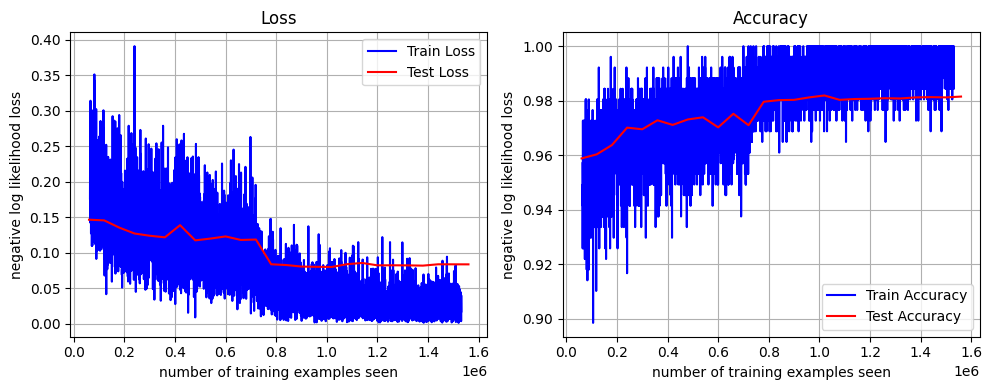

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(train_counter[250:6000], train_losses[250:6000], label = "Train Loss", color='blue')
ax[0].plot(test_counter[1:27], test_losses[1:27], label = "Test Loss", color='red')
ax[0].set_title("Loss")
ax[0].legend(loc="upper right")
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative log likelihood loss')
ax[0].grid(True)

ax[1].plot(train_counter[250:6000], train_accuracy[250:6000], label = "Train Accuracy", color='blue')
ax[1].plot(test_counter[1:27], test_accuracy[1:27], label = "Test Accuracy", color='red')
ax[1].set_title("Accuracy")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('negative log likelihood loss')
ax[1].grid(True)
plt.tight_layout(h_pad=5)

### Further Resources
[1] A lot of the material is taken/inspired from Martin Gorner's presentation https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd<br>
[2] Amazing coursera course: https://www.coursera.org/specializations/deep-learning <br>
[3] For people who want to get on the math side: https://ocw.mit.edu/courses/mathematics/18-065-matrix-methods-in-data-analysis-signal-processing-and-machine-learning-spring-2018/